<div class="description user_content student-version enhanced"><h2>Overview</h2>
<p class="western">The goal of this exercise is to place one or more “annotation points” on a training image of an object, and automatically show those points in the correct place on the object in subsequent query images. For example, in the left figure below, I manually placed three annotation points on a training image of a printer, showing semantically meaningful locations. The right image shows those annotations correctly placed on a query image.</p>
<p class="western">
    <img src="https://elearning.mines.edu/courses/25410/files/1931671/download?wrap=1" alt="printer" width="327" height="261" data-api-endpoint="https://elearning.mines.edu/api/v1/courses/25410/files/1931671" data-api-returntype="File" style="max-width: 327px;">
    <img src="https://elearning.mines.edu/courses/25410/files/1931672/download?wrap=1" alt="printer" width="330" height="264" data-api-endpoint="https://elearning.mines.edu/api/v1/courses/25410/files/1931672" data-api-returntype="File" style="max-width: 330px;"></p>
<p class="western">The approach we will take is to extract features (keypoints and descriptors) from the training image, then match them to features from the query image. We then fit a 2D affine transformation to the potential matches and use RANSAC to eliminate outliers. Once we have the affine matrix, we use it to transform the locations of the annotation points in the training image to their locations in the query image.</p>
<p class="western">On the course website is a training image <a class="instructure_file_link instructure_image_thumbnail" title="printer_001.png" href="/courses/25410/files/2328358/download?wrap=1" data-api-endpoint="https://elearning.mines.edu/api/v1/courses/25410/files/2328358" data-api-returntype="File">printer_001.png</a>. Pick one or more points on this object to annotate and manually determine their (x,y) locations. To do this, you can use any program that displays the location of the mouse, such as “Paint” in Windows.</p>
<p class="western">Write a program that extract features (keypoints and descriptors) from the training image. Then for each query image, do the following:</p>
<ul>
<li>
<p>Extract features from the query image.</p>
</li>
<li>
<p>Match features between the training and query image. Use the “ratio test” to eliminate ambiguous matches.</p>
</li>
<li>
<p>Fit a 2D affine transformation to the matches, using RANSAC to eliminate outliers.</p>
</li>
<li>
<p>If the number of inlier matches exceeds a minimum threshold, then the object has been found. Apply the affine transform matrix to map the annotation points from the training image to the query image, and display the query image with the annotation points in the appropriate places.</p>
</li>
</ul>
<p class="western">Note – a critical parameter in this algorithm is the threshold number of inlier matches. If the threshold is too low, you may have “false positives”, meaning that you detect the object where it is not actually present. If the threshold is too high, you may have “false negatives”, meaning that you miss detecting the object even if where it is actually present.</p>
<p class="western">Apply your program to each image in the folder <a class="instructure_file_link" title="query_images.zip" href="/courses/25410/files/2328367/download?wrap=1" data-api-endpoint="https://elearning.mines.edu/api/v1/courses/25410/files/2328367" data-api-returntype="File">query_images.zip</a>. Adjust the threshold so that your program achieves the highest accuracy on this data, measured as the number of correctly classified images.</p>
<p class="western">Upload:</p>
<ul>
<li class="western">Your python program</li>
<li class="western">A pdf file containing the following:
<ul>
<li class="western">The threshold that you used.</li>
<li class="western">Which images were classified correctly.</li>
<li class="western">Show the training image with your annotations.</li>
<li class="western">Show at least two examples of query images, with the annotations correctly placed.</li>
</ul>
</li>
</ul></div>

In [31]:
import os
import cv2
import numpy as np
from glob import glob

from IPython.display import display, HTML
import ipywidgets as widgets  # Using the ipython notebook widgets
import IPython

#Use 'jpeg' instead of 'png' (~5 times faster)
import PIL.Image
from io import BytesIO

#Use 'jpeg' instead of 'png' (~5 times faster)
def imdisplay(img, fmt='jpeg',width=500):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_p = PIL.Image.fromarray(img)    
    f = BytesIO()
    if new_p.mode != 'RGB':
        new_p = new_p.convert('RGB')
    new_p.save(f, fmt)
    return IPython.display.Image(data=f.getvalue(), width=width)


from IPython.display import Javascript
def preventScrolling():
    disable_js = """
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
    """
    display(Javascript(disable_js))

preventScrolling()


<IPython.core.display.Javascript object>

In [32]:
# Calculate an affine transformation from the training image to the query image.
def calc_affine_transformation(matches_in_cluster, kp_train, kp_query):
    # Not enough matches to calculate affine transformation.
    if len(matches_in_cluster) < 3:
        return None, None


    # Estimate affine transformation from training to query image points.
    src_pts = np.float32(
        [kp_train[m.trainIdx].pt for m in matches_in_cluster]).reshape(-1, 1, 2)
    dst_pts = np.float32(
        [kp_query[m.queryIdx].pt for m in matches_in_cluster]).reshape(-1, 1, 2)

    A_train_query, inliers = cv2.estimateAffine2D(src_pts, dst_pts, 
                                                  method=cv2.RANSAC, 
                                                  ransacReprojThreshold=1,    # Default = 3
                                                  maxIters=20000,              # Default = 2000
                                                  confidence=0.8,            # Default = 0.99
                                                  refineIters=100)             # Default = 10
                                                  
    return A_train_query, inliers

In [33]:
# Detect features in the image and return the keypoints and descriptors.
def detect_features(bgr_img, show_features=False):
    detector = cv2.ORB_create()
    # Extract keypoints and descriptors from image.
    gray_image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = detector.detectAndCompute(gray_image, mask=None)

    # Optionally draw detected keypoints.
    if show_features:
        # Possible flags: DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, DRAW_MATCHES_FLAGS_DEFAULT
        bgr_display = bgr_img.copy()
        cv2.drawKeypoints(image=bgr_display, keypoints=keypoints,
                          outImage=bgr_display,
                          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#         cv2.imshow("Features", bgr_display)
        print("Number of keypoints: ", len(keypoints))

    return keypoints, descriptors

In [68]:
def main():    
    IMAGE_DIRECTORY = "images"
    TRAINING_IMAGE_NAME = "printer_001.png"
    MINIMUM_MATCHES = 5
    
    POSTIVE_QUERY_IMAGE_NAMES = glob("./query_images/positive*")
    NEGATIVE_QUERY_IMAGE_NAMES = glob("./query_images/negative*")  
    bgr_train = cv2.imread(TRAINING_IMAGE_NAME)     # Get training image
    
    # Center coordinates
    center_coordinates = (120, 50)
    # Radius of circle
    radius = 20
    # Blue color in BGR
    color = (255, 0, 0)
    # Line thickness of 2 px
    thickness = 2

    for file_index, QUERY_IMAGE_NAME in enumerate(POSTIVE_QUERY_IMAGE_NAMES + NEGATIVE_QUERY_IMAGE_NAMES):
        bgr_query = cv2.imread(QUERY_IMAGE_NAME)     # Get query image    

        # Show input images.cv2.imshow("Training image", bgr_train)    
#         cv2.imshow("Query image", bgr_query)# Extract keypoints and descriptors.
        kp_train, desc_train = detect_features(bgr_train, show_features=False)    
        kp_query, desc_query = detect_features(bgr_query, show_features=False)    
        matcher = cv2.BFMatcher.create(cv2.NORM_L2)

        # Match query image descriptors to the training image.    
        # Use k nearest neighbor matching and apply ratio test.
        matches = matcher.knnMatch(desc_query, desc_train, k=2)   

        good = []
        for m, n in matches:
            if m.distance < 0.8 * n.distance:
                good.append(m)  
        matches = good

        print("Number of raw matches between training and query: ", len(matches))

        bgr_matches = cv2.drawMatches(img1 = bgr_query, keypoints1 = kp_query,
                                      img2 = bgr_train, keypoints2 = kp_train,
                                      matches1to2 = matches, 
                                      matchesMask = None, outImg = None)    
#         cv2.imshow("All matches", bgr_matches)
        
        # Calculate an affine transformation from the training image to the query image.
        A_train_query, inliers = calc_affine_transformation(matches, kp_train, kp_query)

        matches = [matches[i] for i in range(len(matches)) if inliers[i] == 1]  
        query_annotation_coords = []
        train_annotation_coords = []
        for match in matches:
            query_annotation_coords.append((int(kp_query[match.queryIdx].pt[1]), int(kp_query[match.queryIdx].pt[0])))
            train_annotation_coords.append((int(kp_train[match.trainIdx].pt[1]), int(kp_train[match.trainIdx].pt[0])))
            
#         cv2.imshow("Inlier matches", bgr_matches)

        # Apply the affine warp to warp the training image to the query image.
        if A_train_query is not None and sum(inliers) >= MINIMUM_MATCHES:
            # Object detected! Warp the training image to the query image and blend the images.
            if file_index < 10:
                print("CORRECT\n\tObject detected! Found %d inlier matches" % sum(inliers), "\t", file_index)        
                warped_training = cv2.warpAffine(src=bgr_train, M=A_train_query,
                                 dsize=(bgr_query.shape[1], bgr_query.shape[0]))
                img_annotation1 = bgr_train.copy()
                img_annotation2 = bgr_query.copy()
                for point in query_annotation_coords:
                    cv2.drawMarker(img_annotation1, point, color=(0,255,0), markerType=cv2.MARKER_CROSS, thickness=2)
                for point in train_annotation_coords:
                    cv2.drawMarker(img_annotation2, point, color=(0,255,0), markerType=cv2.MARKER_CROSS, thickness=2)
                # Blend the images.
                blended_image = bgr_query / 2
                blended_image[:, : ,1] += warped_training[:, :, 1] / 2
                blended_image[:, :, 2] += warped_training[:, :, 2] / 2
    #             cv2.imshow("Blended", blended_image.astype(np.uint8))
                display(imdisplay(bgr_matches, width=900))
                display(imdisplay(blended_image.astype(np.uint8), width=400))
                display(imdisplay(img_annotation1.astype(np.uint8), width=400))
                display(imdisplay(img_annotation2.astype(np.uint8), width=400))
            else:
                print("WRONG\n\tObject detected and wasn't supposed to be", file_index)

            
        else:
            if file_index > 9:
                print("CORRECT\n\tObject not detected; can't fit an affine transform", file_index)
            else:
                print("WRONG\n\tObject not detected and was supposed to be", file_index)
#         cv2.waitKey(0)

Number of raw matches between training and query:  35
CORRECT
	Object detected! Found 7 inlier matches 	 0


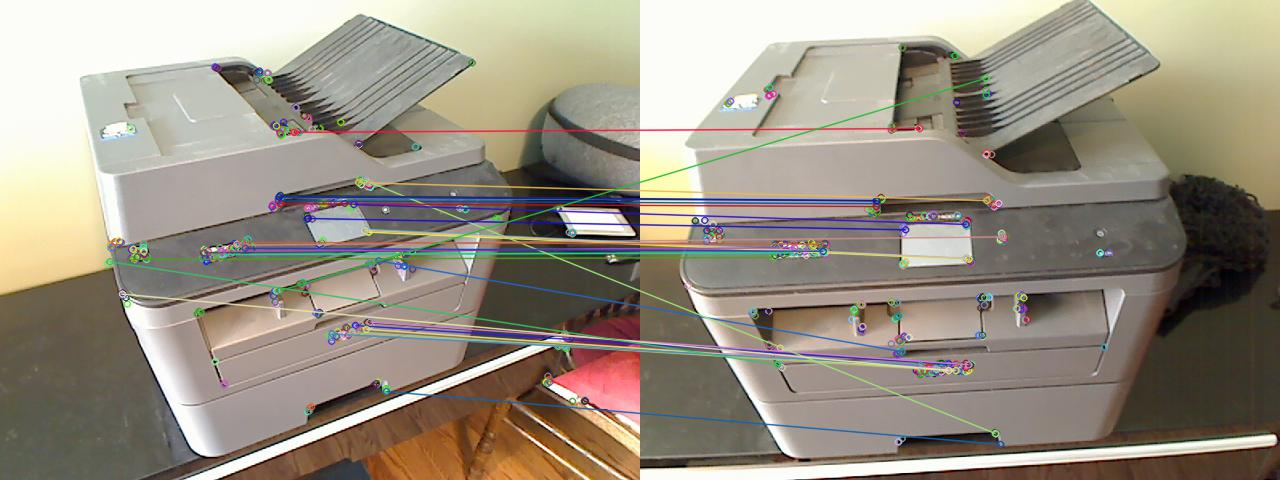

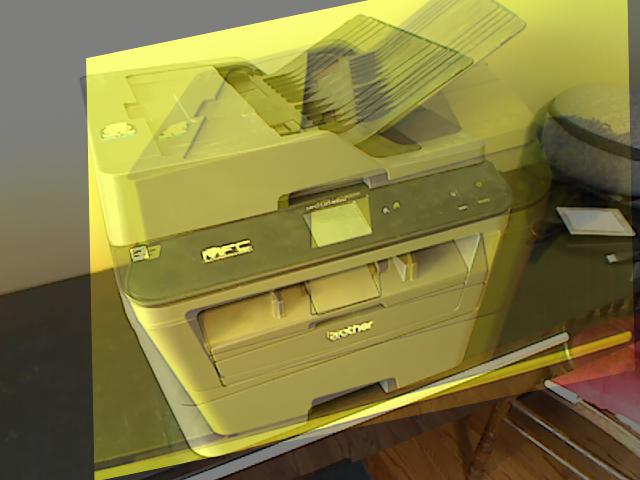

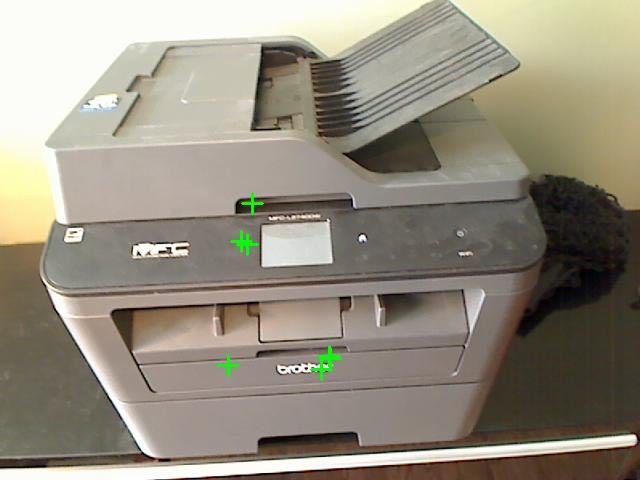

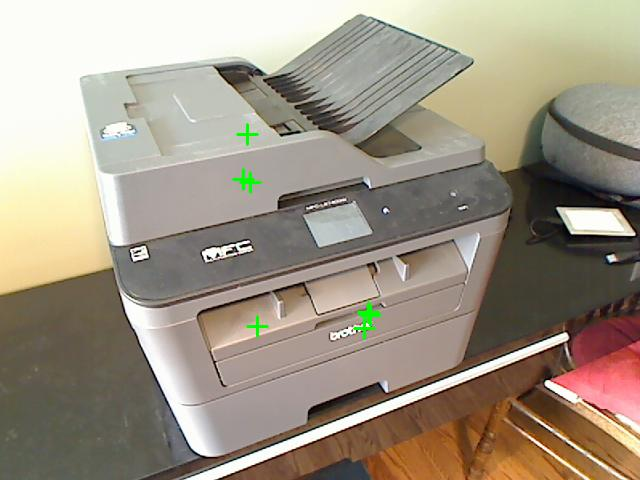

Number of raw matches between training and query:  40
CORRECT
	Object detected! Found 6 inlier matches 	 1


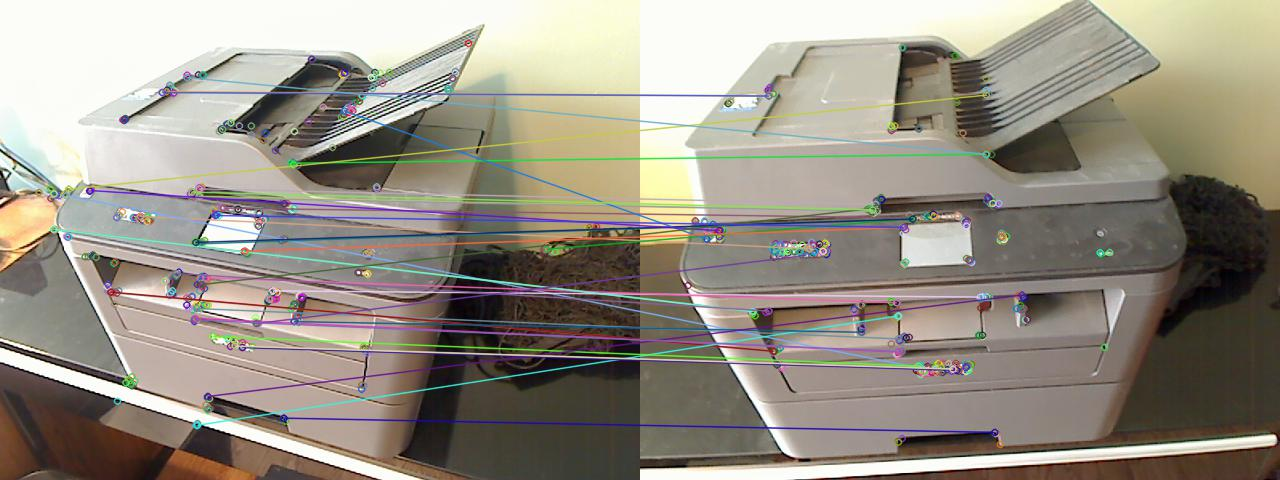

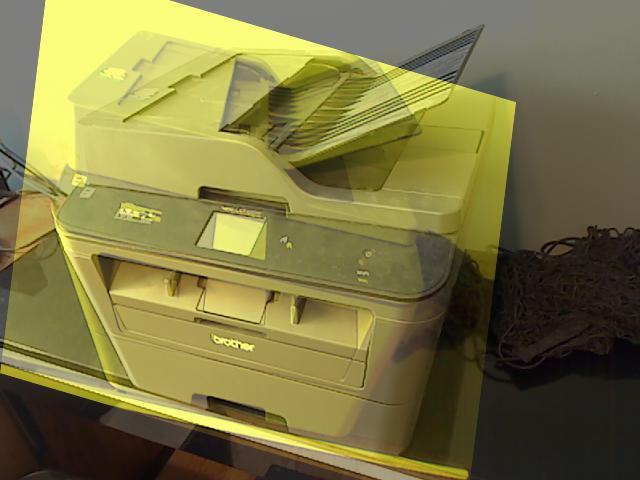

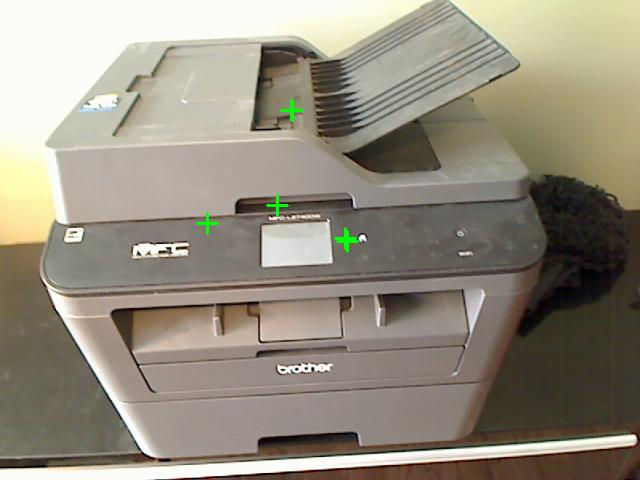

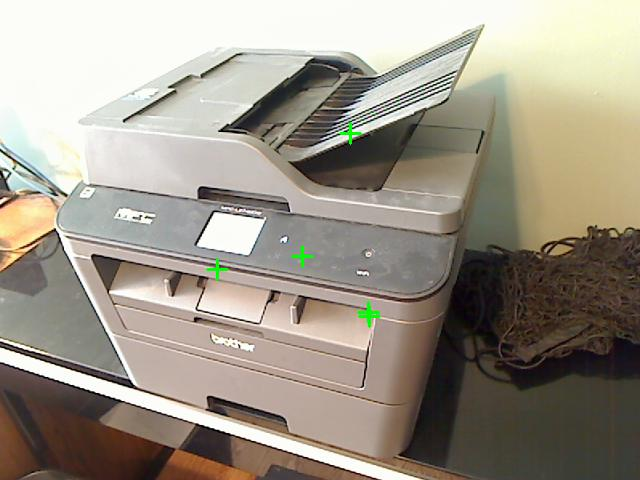

Number of raw matches between training and query:  22
WRONG
	Object not detected and was supposed to be 2
Number of raw matches between training and query:  32
CORRECT
	Object detected! Found 8 inlier matches 	 3


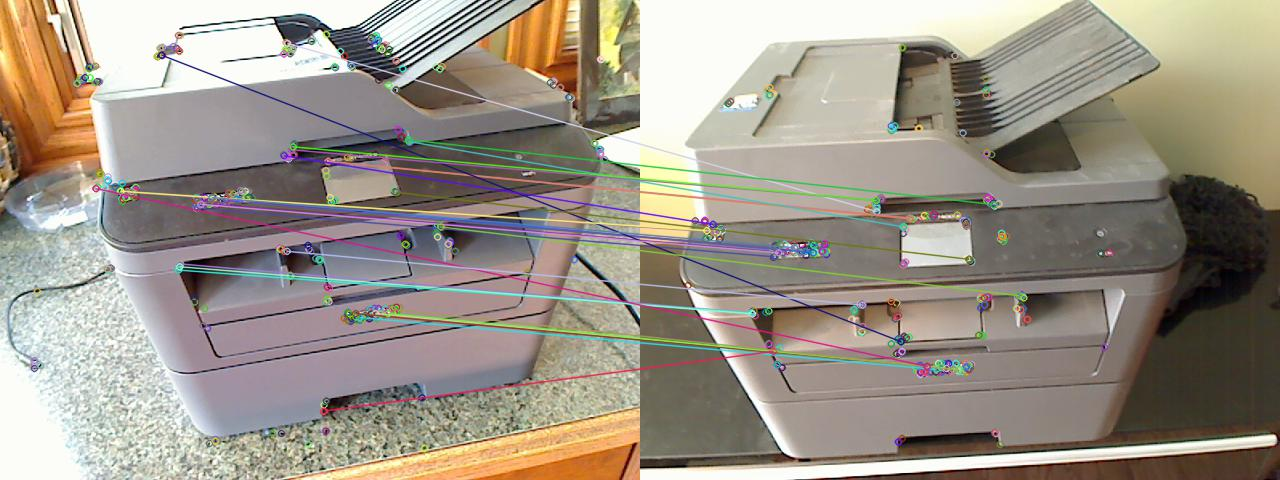

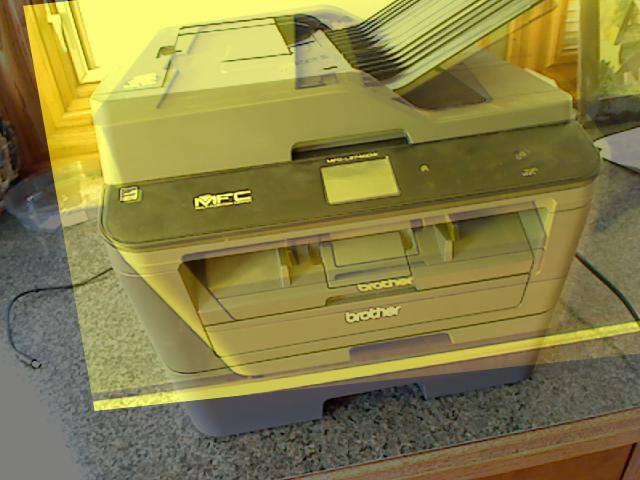

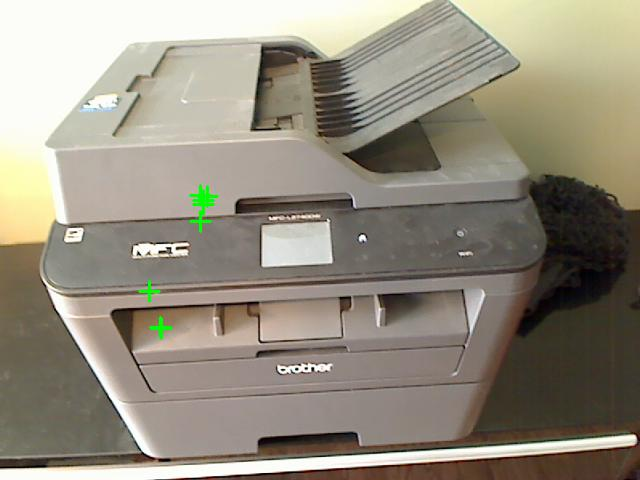

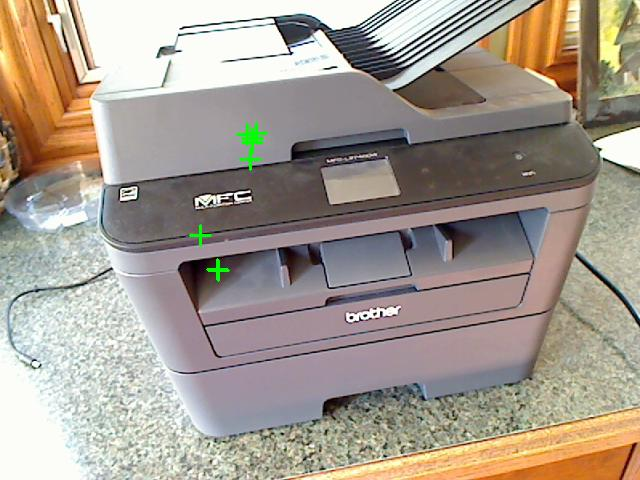

Number of raw matches between training and query:  35
CORRECT
	Object detected! Found 8 inlier matches 	 4


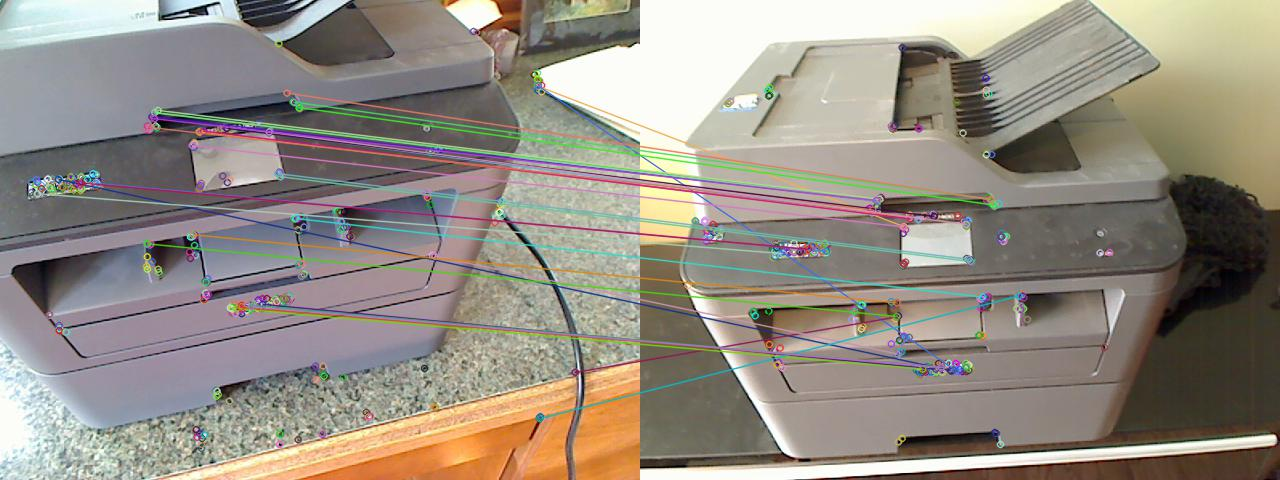

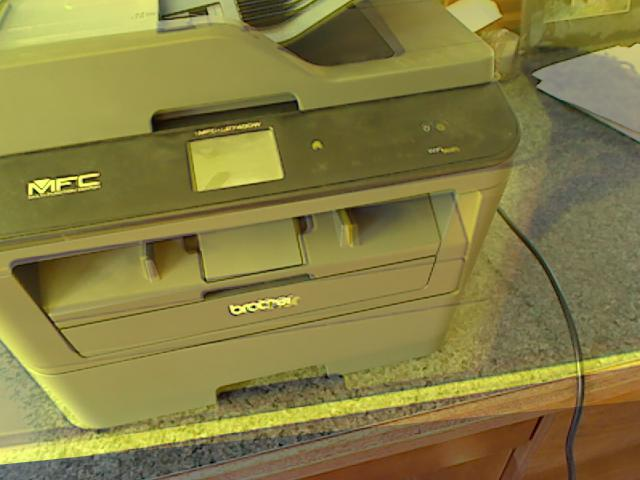

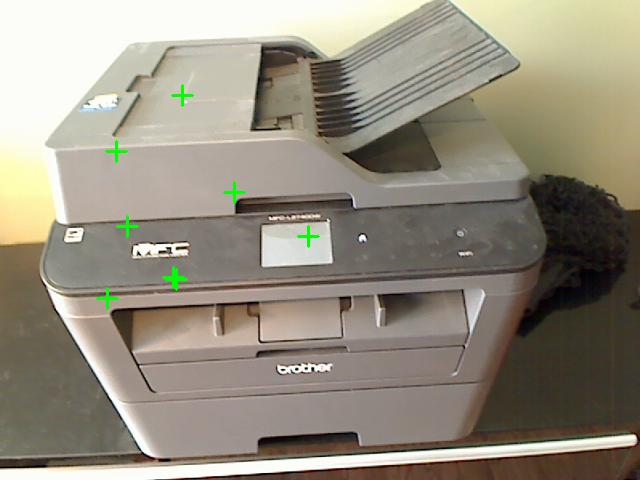

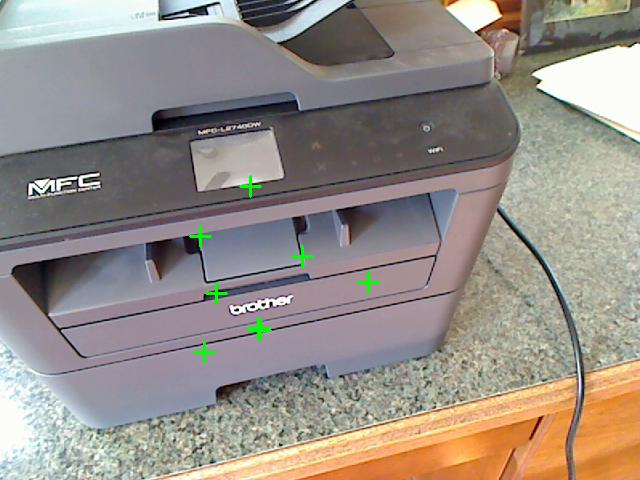

Number of raw matches between training and query:  20
CORRECT
	Object detected! Found 7 inlier matches 	 5


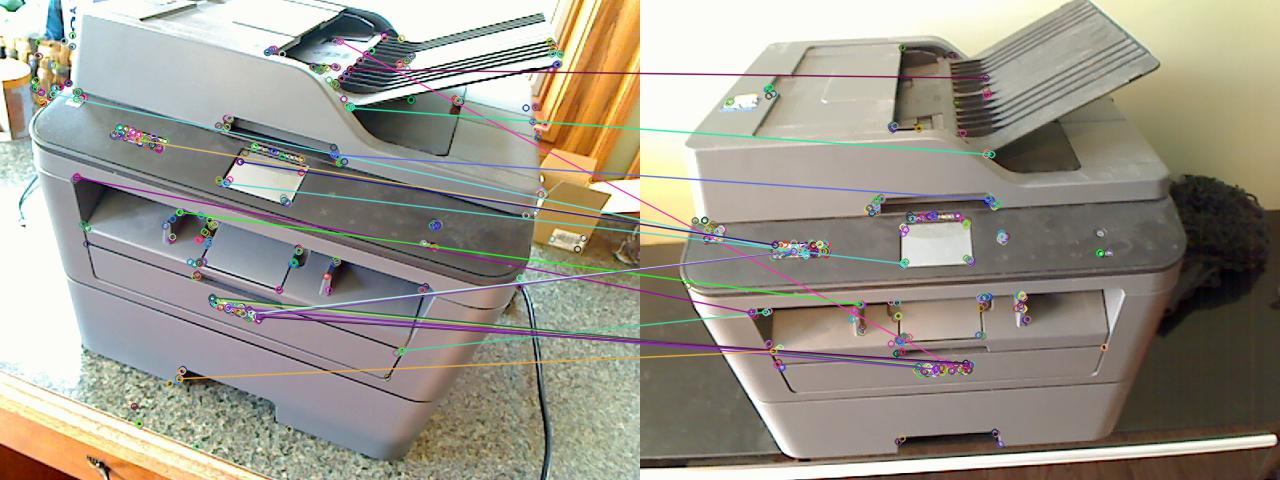

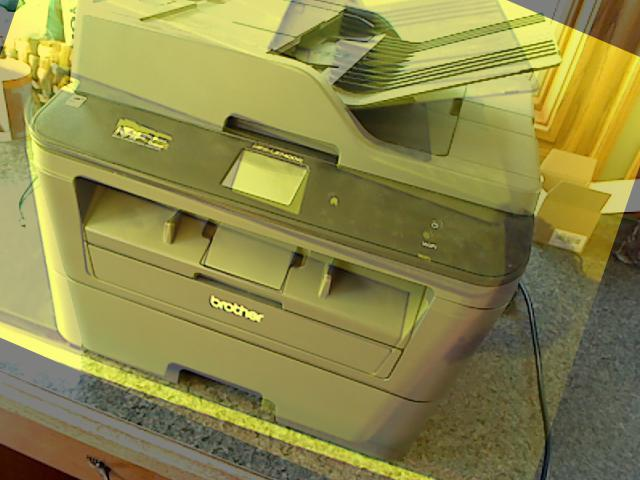

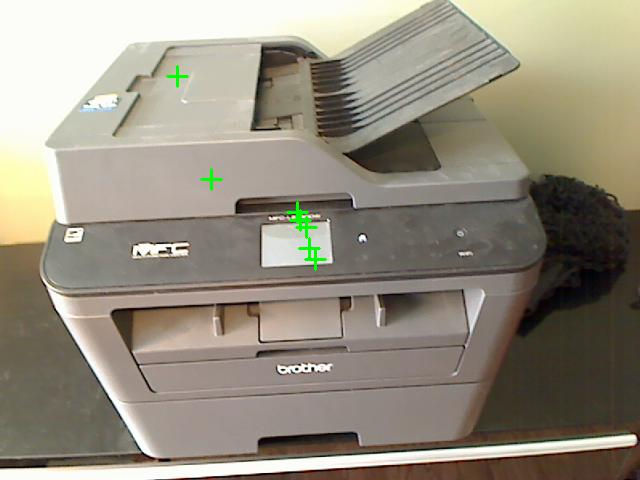

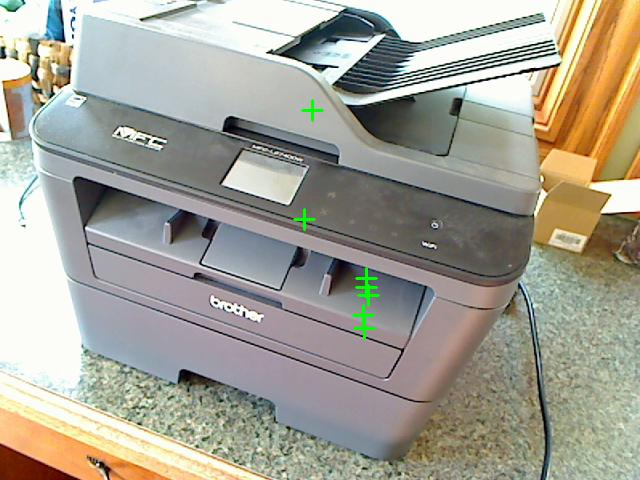

Number of raw matches between training and query:  26
CORRECT
	Object detected! Found 6 inlier matches 	 6


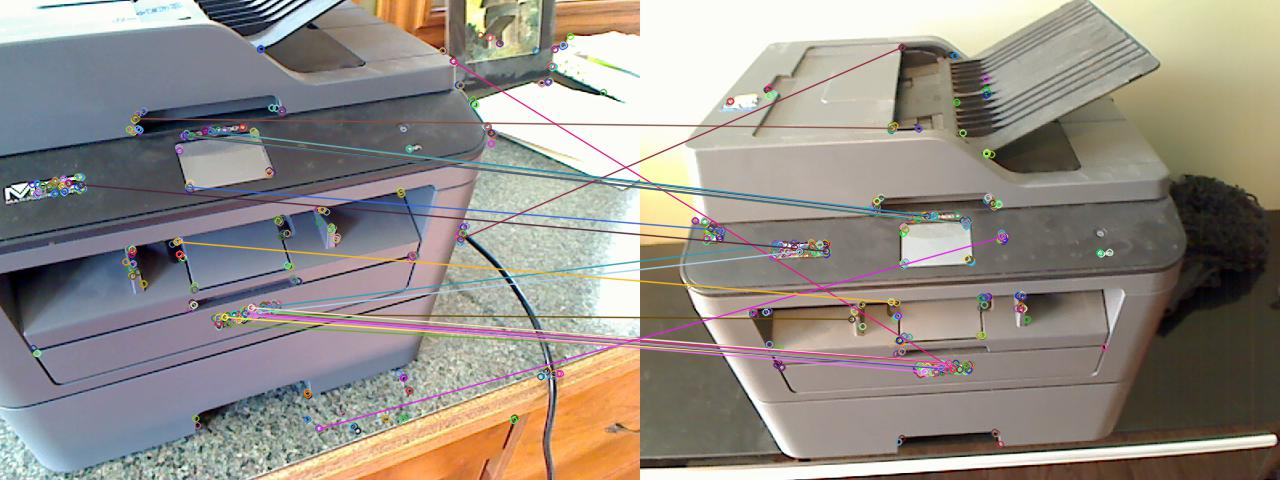

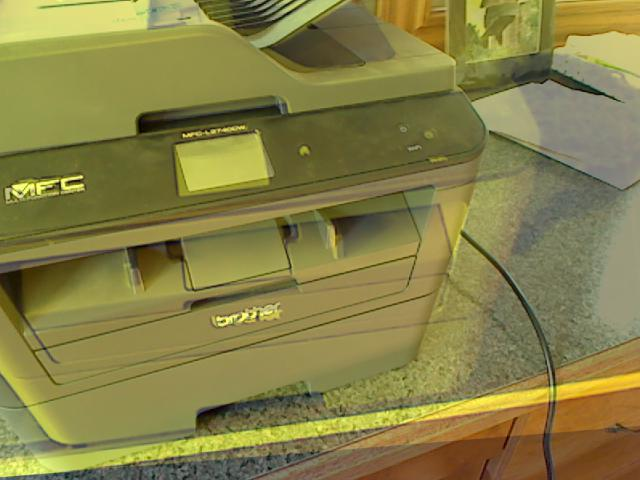

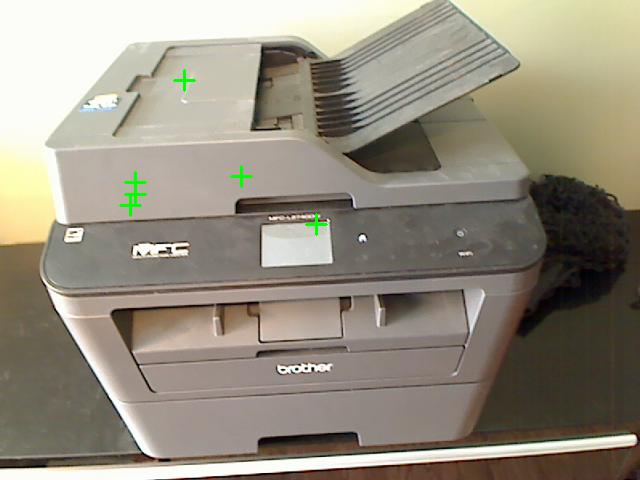

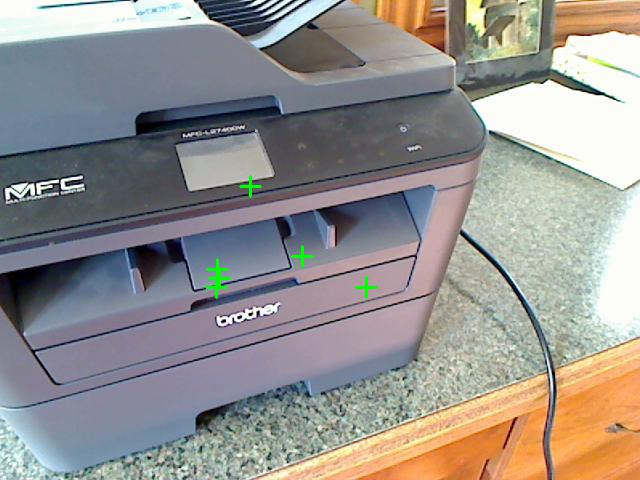

Number of raw matches between training and query:  33
CORRECT
	Object detected! Found 7 inlier matches 	 7


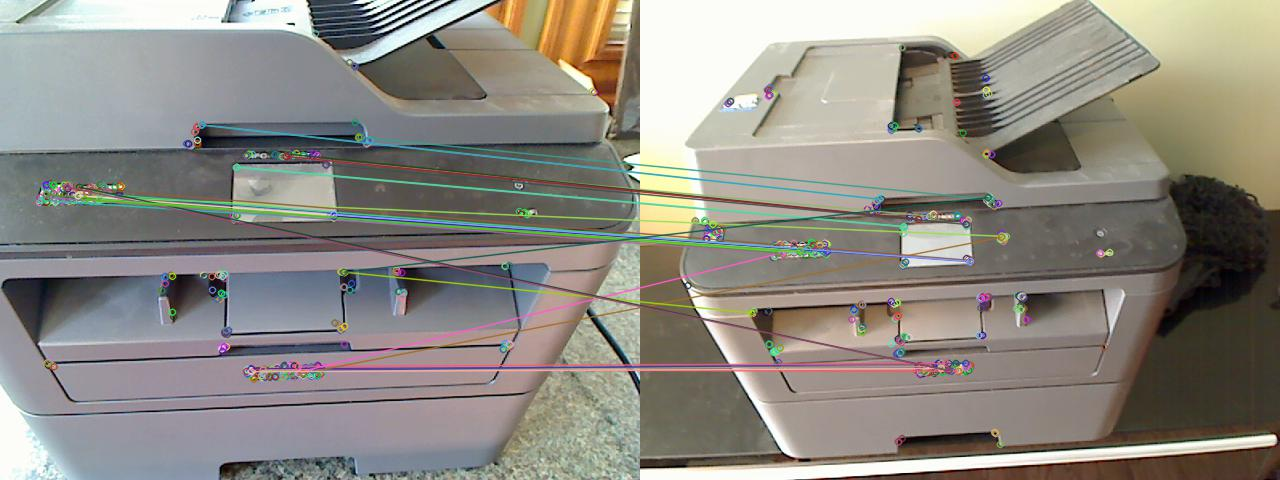

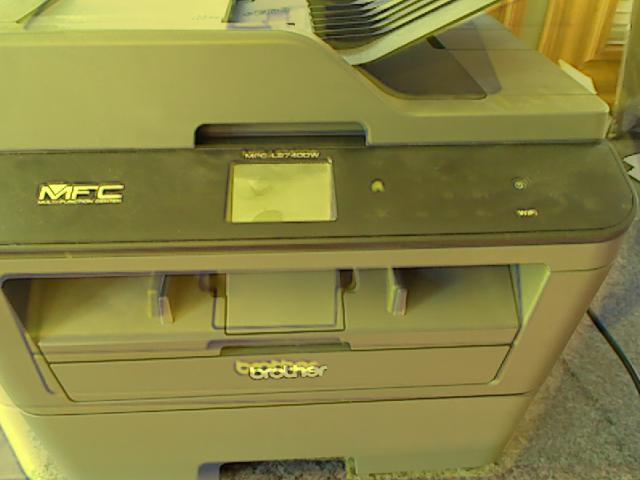

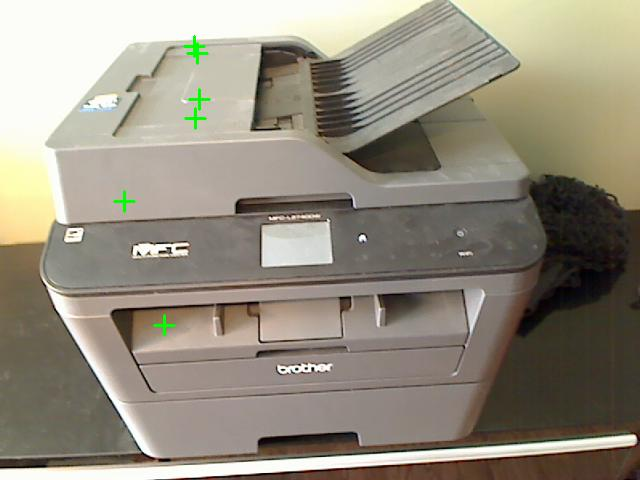

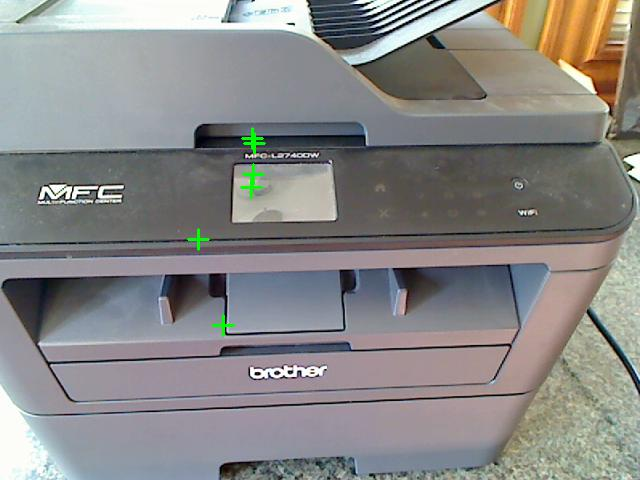

Number of raw matches between training and query:  17
WRONG
	Object not detected and was supposed to be 8
Number of raw matches between training and query:  12
WRONG
	Object not detected and was supposed to be 9
Number of raw matches between training and query:  11
CORRECT
	Object not detected; can't fit an affine transform 10
Number of raw matches between training and query:  10
CORRECT
	Object not detected; can't fit an affine transform 11
Number of raw matches between training and query:  21
WRONG
	Object detected and wasn't supposed to be 12
Number of raw matches between training and query:  12
CORRECT
	Object not detected; can't fit an affine transform 13
Number of raw matches between training and query:  11
CORRECT
	Object not detected; can't fit an affine transform 14
Number of raw matches between training and query:  29
WRONG
	Object detected and wasn't supposed to be 15
Number of raw matches between training and query:  17
CORRECT
	Object not detected; can't fit an affine tran

In [69]:
main()
display(HTML("<h1>Threshold 5<h1>"))